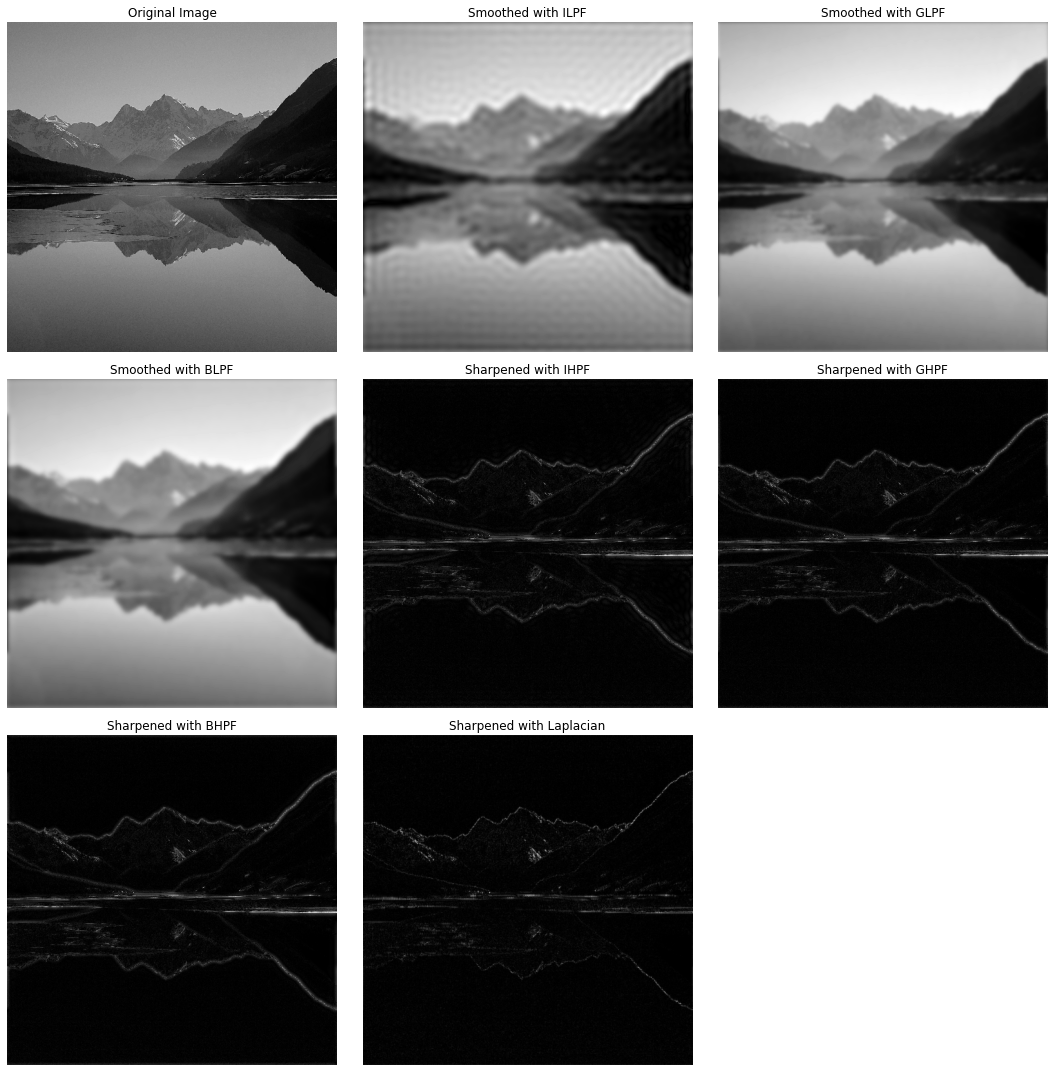

Image 1 Metrics:
MSE: 0.0
PSNR: 100
EPI: 1.0


Image 2 Metrics:
MSE: 1249.0008544921875
PSNR: 17.16517625375188
EPI: 0.20178228723543978


Image 3 Metrics:
MSE: 2123.45751953125
PSNR: 14.860367836588033
EPI: 0.23771574032484047


Image 4 Metrics:
MSE: 1874.6422119140625
PSNR: 15.401619689207829
EPI: 0.20983072200497876


Image 5 Metrics:
MSE: 10893.7568359375
PSNR: 7.759026838897797
EPI: 0.594936638529788


Image 6 Metrics:
MSE: 11074.9560546875
PSNR: 7.687383492454522
EPI: 0.5767770576747194


Image 7 Metrics:
MSE: 11040.8994140625
PSNR: 7.700759075241964
EPI: 0.5810087875040632


Image 8 Metrics:
MSE: 11273.84375
PSNR: 7.610083494526641
EPI: 0.42440592491170465




In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# Step 1: Read the Input Image
def load_and_preprocess_image(image_path, size=(512, 512)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load the image in grayscale
    if img is None:
        raise ValueError("Image not found or path is incorrect.")
    img = cv2.resize(img, size)  # Resize the image to 512x512
    img = np.float32(img)  # Convert to floating point
    return img

# Step 2: Convert Image to Frequency Domain Using FFT
def fft_transform(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)  # Shift the zero frequency to the center
    return fshift

def ifft_transform(fshift_filtered):
    f_ishift = np.fft.ifftshift(fshift_filtered)  # Inverse shift
    img_back = np.fft.ifft2(f_ishift)  # Inverse FFT
    img_back = np.abs(img_back)  # Get magnitude (real part)

    # Normalize the values to the range [0, 255]
    img_back = (img_back - np.min(img_back)) / (np.max(img_back) - np.min(img_back)) * 255  # Scale to [0, 255]
    img_back = np.uint8(img_back)  # Convert to uint8

    return img_back

# Step 3: Frequency Domain Filters
# Ideal Low-Pass Filter (ILPF)
def ideal_low_pass_filter(shape, D0):
    rows, cols = shape
    u = np.arange(rows) - rows // 2
    v = np.arange(cols) - cols // 2
    U, V = np.meshgrid(u, v)
    D = np.sqrt(U**2 + V**2)
    H = np.zeros((rows, cols))
    H[D <= D0] = 1
    return H

# Gaussian Low-Pass Filter (GLPF)
def gaussian_low_pass_filter(shape, D0):
    rows, cols = shape
    u = np.arange(rows) - rows // 2
    v = np.arange(cols) - cols // 2
    U, V = np.meshgrid(u, v)
    D = np.sqrt(U**2 + V**2)
    H = np.exp(-(D**2) / (2 * D0**2))
    return H

# Butterworth Low-Pass Filter (BLPF)
def butterworth_low_pass_filter(shape, D0, n):
    rows, cols = shape
    u = np.arange(rows) - rows // 2
    v = np.arange(cols) - cols // 2
    U, V = np.meshgrid(u, v)
    D = np.sqrt(U**2 + V**2)
    H = 1 / (1 + (D / D0)**(2 * n))
    return H

# Ideal High-Pass Filter (IHPF)
def ideal_high_pass_filter(shape, D0):
    rows, cols = shape
    u = np.arange(rows) - rows // 2
    v = np.arange(cols) - cols // 2
    U, V = np.meshgrid(u, v)
    D = np.sqrt(U**2 + V**2)
    H = np.ones((rows, cols))
    H[D <= D0] = 0
    return H

# Gaussian High-Pass Filter (GHPF)
def gaussian_high_pass_filter(shape, D0):
    rows, cols = shape
    u = np.arange(rows) - rows // 2
    v = np.arange(cols) - cols // 2
    U, V = np.meshgrid(u, v)
    D = np.sqrt(U**2 + V**2)
    H = 1 - np.exp(-(D**2) / (2 * D0**2))
    return H

# Butterworth High-Pass Filter (BHPF)
def butterworth_high_pass_filter(shape, D0, n):
    rows, cols = shape
    u = np.arange(rows) - rows // 2
    v = np.arange(cols) - cols // 2
    U, V = np.meshgrid(u, v)
    D = np.sqrt(U**2 + V**2)
    H = 1 - 1 / (1 + (D / D0)**(2 * n))  # Corrected formula
    return H

# Laplacian High-Pass Filter
def laplacian_high_pass_filter(shape):
    rows, cols = shape
    u = np.arange(rows) - rows // 2
    v = np.arange(cols) - cols // 2
    U, V = np.meshgrid(u, v)
    D = np.sqrt(U**2 + V**2)
    H = D**2
    return H

# Performance Metrics
def mse(original, processed):
    return np.mean((original - processed) ** 2)

def psnr(original, processed, max_value=255):
    mse_value = mse(original, processed)
    if mse_value == 0:
        return 100  # No noise, the images are identical
    return 10 * np.log10((max_value ** 2) / mse_value)

def edge_preservation_index(original, processed):
    grad_original_x = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=3)
    grad_original_y = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=3)
    grad_original = np.sqrt(grad_original_x**2 + grad_original_y**2)

    grad_processed_x = cv2.Sobel(processed, cv2.CV_64F, 1, 0, ksize=3)
    grad_processed_y = cv2.Sobel(processed, cv2.CV_64F, 0, 1, ksize=3)
    grad_processed = np.sqrt(grad_processed_x**2 + grad_processed_y**2)

    numerator = np.sum(grad_original * grad_processed)
    denominator = np.sum(grad_original ** 2)
    return numerator / denominator if denominator != 0 else 0

# Display Image using Subplots
def display_images_in_grid(titles, images, rows, cols):
    plt.figure(figsize=(15, 15))
    for i, (title, img) in enumerate(zip(titles, images)):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Main function
def main(image_path):
    img = load_and_preprocess_image(image_path)

    # Step 2: FFT and shift
    fshift = fft_transform(img)

    # Step 3: Apply filters (for smoothing and sharpening)
    D0 = 30  # Cutoff frequency
    n = 2  # Order for Butterworth filter

    # Low-pass filters for smoothing
    ilpf = ideal_low_pass_filter(img.shape, D0)
    glpf = gaussian_low_pass_filter(img.shape, D0)
    blpf = butterworth_low_pass_filter(img.shape, D0, n)

    # High-pass filters for sharpening
    ihpf = ideal_high_pass_filter(img.shape, D0)
    ghpf = gaussian_high_pass_filter(img.shape, D0)
    bhpf = butterworth_high_pass_filter(img.shape, D0, n)
    laplacian = laplacian_high_pass_filter(img.shape)

    # Apply filters and inverse FFT
    smoothed_images = [
        img,
        ifft_transform(fshift * ilpf),
        ifft_transform(fshift * glpf),
        ifft_transform(fshift * blpf)
    ]
    sharpened_images = [
        ifft_transform(fshift * ihpf),
        ifft_transform(fshift * ghpf),
        ifft_transform(fshift * bhpf),
        ifft_transform(fshift * laplacian)
    ]

    # Display processed images (smoothed and sharpened)
    titles_smoothed = ['Original Image','Smoothed with ILPF', 'Smoothed with GLPF', 'Smoothed with BLPF']
    titles_sharpened = ['Sharpened with IHPF', 'Sharpened with GHPF', 'Sharpened with BHPF', 'Sharpened with Laplacian']
    images_smoothed = smoothed_images
    images_sharpened = sharpened_images

    display_images_in_grid(titles_smoothed + titles_sharpened, images_smoothed + images_sharpened, 3, 3)

    # Calculate performance metrics
    for i, filtered_img in enumerate(smoothed_images + sharpened_images):
        mse_value = mse(img, filtered_img)
        psnr_value = psnr(img, filtered_img)
        epi_value = edge_preservation_index(img, filtered_img)
        print(f"Image {i+1} Metrics:")
        print(f"MSE: {mse_value}")
        print(f"PSNR: {psnr_value}")
        print(f"EPI: {epi_value}")
        print("\n")

if __name__ == "__main__":
    image_path = 'C:/Users/Student/Documents/Img processing/image.jpg'
    main(image_path)